In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from hyperopt import hp

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# ElasticNet tuning

In [2]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

In [3]:
data, y = make_regression(
    n_samples=100000, n_features=20, n_informative=10, noise=30)
data = pd.DataFrame(data=data, columns=['f'+str(i+1) for i in range(data.shape[1])])
# Make data positive, add some non-linearity and 5% of outliers.
y = (y + abs(y.min())) ** 1.5
y[np.random.choice(range(len(y)), int(len(y)*0.1))] += y.max()
y /= 1000

features = [c for c in data.columns]
train, test, ytrain, ytest = train_test_split(data[features], y, test_size=0.25)

scaler = StandardScaler()
train = pd.DataFrame(data=scaler.fit_transform(train),  columns=features)
test  = pd.DataFrame(data=scaler.transform(test),  columns=features)

In [4]:
base_params = {'max_iter': 10000}
tunable_params = {
    'alpha'         :hp.uniform('alpha',  1e-5, 10),
    'l1_ratio'      :hp.uniform('l1_ratio', 0, 1),
    'fit_intercept' :hp.choice('fit_intercept', [True, False]),
    'tol'           :hp.choice('tol', [1e-6, 1e-5, 1e-4, 1e-3])
}
integer_params = []

In [5]:
from tuner import Tuner
T = Tuner(
    train=train, ytrain=ytrain,
    model=ElasticNet, maximize=False,
    base_params=base_params,
    tunable_params=tunable_params,
    integer_params=integer_params,
    n_splits=3, split_seed=0, stratify=False,
    metric=mean_squared_error
)

Started 1 epoch of tuning
Default parameters score for current folds: 497.8511
100 trials are done in 0.2 minutes. Best metric achieved is 481.4861

Started 2 epoch of tuning
Default parameters score for current folds: 497.8407
30 trials are done in 0.0 minutes. Best metric achieved is 481.5241

Started 3 epoch of tuning
Default parameters score for current folds: 497.8874
10 trials are done in 0.0 minutes. Best metric achieved is 481.491



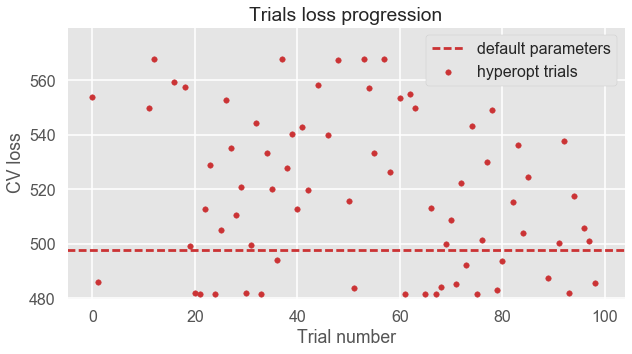

,params,num_iters,checks,total_loss,1_epoch_loss,2_epoch_loss,3_epoch_loss
0,"{'fit_intercept': True, 'tol': 1e-05, 'alpha':...",0,3,1444.501468,481.486086,481.524076,481.491306
1,"{'fit_intercept': True, 'tol': 1e-05, 'alpha':...",0,3,1444.504376,481.487032,481.526374,481.490970
2,"{'fit_intercept': True, 'tol': 1e-05, 'alpha':...",0,3,1444.571166,481.509148,481.552264,481.509754
3,"{'fit_intercept': True, 'tol': 1e-05, 'alpha':...",0,3,1444.588899,481.514458,481.549636,481.524805
4,"{'fit_intercept': True, 'tol': 1e-05, 'alpha':...",0,3,1444.717802,481.557943,481.600681,481.559178


In [6]:
T.tune([100, 30, 10])
T.plot_1_epoch_results()
T.results.head()

In [7]:
# We can see that linear model does not overfit to folds even on noisy small data.
model = T.model(**base_params)
model = model.fit(train, ytrain)
print('Base model:', T.metric(ytest, model.predict(test)))

model = T.model(**T.results.sort_values('1_epoch_loss', ascending=not T.maximize).iloc[0].params)
model = model.fit(train, ytrain)
print('Best model after first epoch on test:', T.metric(ytest, model.predict(test)))

model = T.model(**T.results.iloc[0].params)
model = model.fit(train, ytrain)
print('Best model after all epochs on test:', T.metric(ytest, model.predict(test)))

print('\nBest parameters:')
print(T.results.iloc[0].params)

Base model: 499.915012263
Best model after first epoch on test: 483.262041508
Best model after all epochs on test: 483.262041508

Best parameters:
{'fit_intercept': True, 'tol': 1e-05, 'alpha': 0.03242309284619656, 'l1_ratio': 0.6789065606247552, 'max_iter': 10000}


# KNeighborsClassifier tuning

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [9]:
data, y = make_classification(
    n_classes=5, n_samples=5000, n_features=15, n_informative=5, n_redundant=2, flip_y=0.05)
data = pd.DataFrame(data=data, columns=['f'+str(i+1) for i in range(data.shape[1])])

features = list(data.columns)
train, test, ytrain, ytest = train_test_split(data, y, test_size=0.25)

scaler = StandardScaler()
train = pd.DataFrame(data=scaler.fit_transform(train),  columns=features)
test  = pd.DataFrame(data=scaler.transform(test),  columns=features)

In [10]:
base_params = {'n_jobs': -1}
tunable_params = {
    'n_neighbors' :hp.quniform('n_neighbors',  5, 200, 1),
    'leaf_size'   :hp.quniform('leaf_size', 10, 500, 10),
    'weights'     :hp.choice('weights', ['uniform', 'distance']),
    'p'           :hp.choice('p', [1, 2])
}
integer_params = ['n_neighbors', 'leaf_size']

In [11]:
from tuner import Tuner
T = Tuner(
    train=train, ytrain=ytrain,
    model=KNeighborsClassifier, maximize=True,
    base_params=base_params,
    tunable_params=tunable_params,
    integer_params=integer_params,
    n_splits=3, split_seed=0, stratify=True,
    metric=accuracy_score, return_labels=True
)

Started 1 epoch of tuning
Default parameters score for current folds: 0.5299
50 trials are done in 0.3 minutes. Best metric achieved is 0.6309

Started 2 epoch of tuning
Default parameters score for current folds: 0.5371
15 trials are done in 0.1 minutes. Best metric achieved is 0.6288

Started 3 epoch of tuning
Default parameters score for current folds: 0.5275
5 trials are done in 0.0 minutes. Best metric achieved is 0.6247



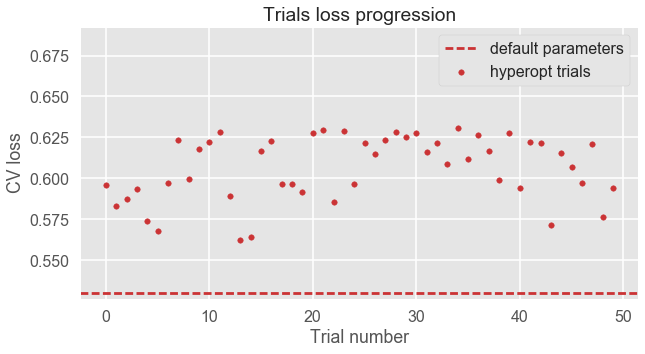

,params,num_iters,checks,total_loss,1_epoch_loss,2_epoch_loss,3_epoch_loss
0,"{'n_jobs': -1, 'weights': 'distance', 'p': 1, ...",0,3,1.881067,0.629600,0.628800,0.622667
1,"{'n_jobs': -1, 'weights': 'distance', 'p': 1, ...",0,3,1.880000,0.630933,0.626667,0.622400
2,"{'n_jobs': -1, 'weights': 'distance', 'p': 1, ...",0,3,1.877333,0.628267,0.625067,0.624000
3,"{'n_jobs': -1, 'weights': 'distance', 'p': 1, ...",0,3,1.877333,0.627467,0.627200,0.622667
4,"{'n_jobs': -1, 'weights': 'distance', 'p': 1, ...",0,3,1.876800,0.628800,0.627200,0.620800


In [12]:
T.tune([50, 15, 5])
T.plot_1_epoch_results()
T.results.head()

In [13]:
model = T.model(**base_params)
model = model.fit(train, ytrain)
print('Base model:', T.metric(ytest, model.predict(test)))

model = T.model(**T.results.sort_values('1_epoch_loss', ascending=not T.maximize).iloc[0].params)
model = model.fit(train, ytrain)
print('Best model after first epoch on test:', T.metric(ytest, model.predict(test)))

model = T.model(**T.results.iloc[0].params)
model = model.fit(train, ytrain)
print('Best model after all epochs on test:', T.metric(ytest, model.predict(test)))

print('\nBest parameters:')
print(T.results.iloc[0].params)

Base model: 0.5616
Best model after first epoch on test: 0.6376
Best model after all epochs on test: 0.64

Best parameters:
{'n_jobs': -1, 'weights': 'distance', 'p': 1, 'leaf_size': 160, 'n_neighbors': 32}
